# SVM with rbf kernel

The goal of this notebook is to find the best parameters for polynomial kernel. We also want to check if the parameters depend on stock.

We will use [sklearn.svm](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) library to perform calculations. We want to pick the best parameters for **SVC**:

* C (default 1.0)
* gamma (default 1/number_of_features, so 1 in our case)

Kernel function looks like this: $\exp(-\gamma \|x-x'\|^2)$. $\gamma$ is specified by keyword **gamma**, must be greater than 0.

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import svm
import warnings

from lob_data_utils import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks (from dates 2013-09-01 - 2013-11-16) for which logistic regression yielded the best results.

We selected 3 subsets for each stock:
* training set (60% of data)
* test set (20% of data)
* cross-validation set (20% of data)

In [2]:
stocks = ['9061', '9062', '9063', '9064', '9065']

dfs = {}
dfs_cv = {}
dfs_test = {}

for s in stocks:
    df, df_cv, df_test = lob.load_data(s, cv=True)
    dfs[s] = df
    dfs_cv[s] = df_cv
    dfs_test[s] = df_test

Training set length for 9061: 10347
Testing set length for 9061: 3449
Cross-validation set length for 9061: 3449
Training set length for 9062: 10531
Testing set length for 9062: 3510
Cross-validation set length for 9062: 3510
Training set length for 9063: 9921
Testing set length for 9063: 3306
Cross-validation set length for 9063: 3306
Training set length for 9064: 10606
Testing set length for 9064: 3535
Cross-validation set length for 9064: 3535
Training set length for 9065: 7732
Testing set length for 9065: 2576
Cross-validation set length for 9065: 2576


In [3]:
dfs[stocks[0]].head(5)

,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2013-09-16 13:05:00,"[(550.0, 6364.0), (615.0, 273.0), (630.0, 1510...","[(706.2, 5181.0), (706.3, 9406.0), (706.4, 154...",706.0,706.2,706.10,5181.0,5261.0,0.0,0.007661
2013-09-16 13:07:00,"[(550.0, 6364.0), (615.0, 273.0), (630.0, 1510...","[(706.1, 7224.0), (706.2, 16599.0), (706.3, 26...",705.8,706.1,705.95,7224.0,5045.0,0.0,-0.177602
2013-09-16 13:08:00,"[(550.0, 6364.0), (615.0, 273.0), (630.0, 1510...","[(705.9, 582.0), (706.0, 11310.0), (706.1, 105...",705.7,705.9,705.80,582.0,2000.0,0.0,0.549187
2013-09-16 13:09:00,"[(550.0, 6364.0), (615.0, 273.0), (630.0, 1510...","[(705.8, 5031.0), (705.9, 8507.0), (706.0, 138...",705.6,705.8,705.70,5031.0,1292.0,0.0,-0.591333
2013-09-16 13:10:00,"[(550.0, 6364.0), (615.0, 273.0), (630.0, 1510...","[(705.6, 7042.0), (705.7, 14234.0), (705.8, 25...",705.3,705.6,705.45,7042.0,5785.0,0.0,-0.097996


In [4]:
def svm_classification(d, kernel, gamma='auto', C=1.0):
    clf = svm.SVC(kernel=kernel, gamma=gamma, C=C)
    X = d['queue_imbalance'].values.reshape(-1, 1)
    y = d['mid_price_indicator'].values.reshape(-1, 1)
    clf.fit(X, y)
    return clf

# Methodology

We will use at first naive approach to grasp how each of the parameter influences the ROC area score and what values make sense, when the other parameters are set to defaults.

After that we will try to get the best combination of the parameters.

### C parameter

The C parameter has influence over margin picked by SVM:
* for large values of **C** SVM will choose a smaller-margin hyperplane, which means that more data points will be classified correctly
* for small values of **C** SVM will choose a bigger-margin hyperplane, so there may be more misclassifications

At first we tried parameters: [0.0001, 0.001, 0.01, 0.1, 1, 10, 1000], but after first calculations it seems that it wasn't enough, so a few more values were introduced or removed.

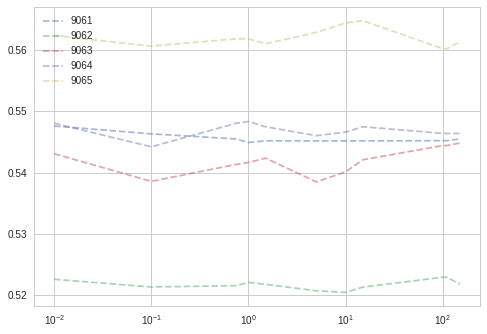

In [5]:
cs = [0.01, 0.1, 0.75, 1, 1.5, 5, 10, 15, 100, 110, 150]
df_css = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_cs = pd.DataFrame(index=cs)
    df_cs['roc'] = np.zeros(len(df_cs))
    for c in cs:
        reg_svm = svm_classification(dfs[s], 'rbf', C=c)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_cs.loc[c] = logit_roc_auc
    plt.plot(df_cs, linestyle='--', label=s, marker='x', alpha=0.5)
    df_css[s] = df_cs
    
plt.legend()

##### Best values of C parameter

There is no rule, how to set this parameter - for stock **11618** the value is very large, for the rest it is rather small.

In [6]:
for s in stocks:
    idx = df_css[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 9061 the best is 0.01
For 9062 the best is 110.0
For 9063 the best is 150.0
For 9064 the best is 1.0
For 9065 the best is 15.0


##### Influence of C parameter

The score difference between SVM with the worst choice of parameter **C** and the best choice one is shown on the output below. For scoring method we used *roc_area*. For two stocks **10795** and **12098** it can affect the prediction by 0.1, for the rest the difference is less.

In [7]:
for s in stocks:
    err_max = df_css[s]['roc'].max()
    err_min = df_css[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 9061 the diff between best and worst 0.002685885106325836
For 9062 the diff between best and worst 0.002481934220301296
For 9063 the diff between best and worst 0.0063512329122638045
For 9064 the diff between best and worst 0.004129902007859343
For 9065 the diff between best and worst 0.0045935077218552944


### Gamma

Gamma is a parameter which has influence over decision region - the bigger it is, the bigger influence every single row of data has. When gamma is low the decision region is very broad. When gamma is high it can even create islands of decision-boundaries around data points.

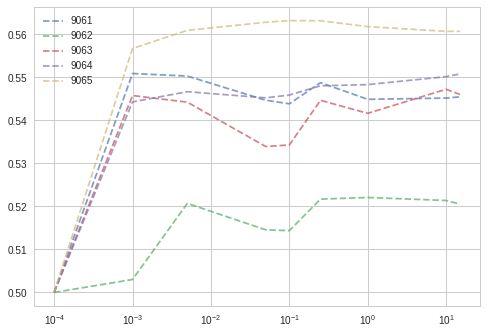

In [8]:
gammas = [0.0001, 0.001, 0.005, 0.05, 0.1, 0.25, 1, 10, 15]

df_gammas = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_gamma = pd.DataFrame(index=gammas)
    df_gamma['roc'] = np.zeros(len(df_gamma))
    for g in gammas:
        reg_svm = svm_classification(dfs[s], 'rbf', gamma=g)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))

        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_gamma.loc[g] = logit_roc_auc
    plt.plot(df_gamma, linestyle='--', label=s, marker='x', alpha=0.7)
    df_gammas[s] = df_gamma
    
plt.legend()

##### Best values of gamma

There is no rule, how to set this parameter - for stock **2051** the value is very large, for the rest it is rather small.

In [9]:
for s in stocks:
    idx = df_gammas[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 9061 the best is 0.001
For 9062 the best is 1.0
For 9063 the best is 10.0
For 9064 the best is 15.0
For 9065 the best is 0.1


##### Influence of gamma

The score difference between SVM with the worst choice of **gamma** and the best choice one is shown on the output below. For scoring method we used *roc_area*. For all stocks the error difference is small - less than 0.04.

In [10]:
for s in stocks:
    err_max = df_gammas[s]['roc'].max()
    err_min = df_gammas[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 9061 the diff between best and worst 0.0509107630435659
For 9062 the diff between best and worst 0.022079928412237493
For 9063 the diff between best and worst 0.047251831251079124
For 9064 the diff between best and worst 0.05081285588253737
For 9065 the diff between best and worst 0.06321980778400627


# Results

We compare results of the SVMs with the best choices of parameters against the logistic regression and SVM with defaults.

We will use two approaches for choosing parameters:
* naive - for each stock we will just pick the best values we found in the previous section
* grid - we will caluclate roc_area error for every combination of parameters used in previous section (computionally heavy).

We could also use GridSearchCV from sklearn library, but the issue with it is supplying the cross-validation set (it has to be continous in time). In the future we need to implement the method for that.

#### Naive approach

We pick the best **C** parameter and the best **gamma** separately from the results of [section above](#Methodology), which were obtained using cross-validation set.

For two stocks **12098** and **11618** the roc_area scores are better, for the rest it's slightly worse for testing set. So this approach doesn't work so well.

In [11]:
df_results = pd.DataFrame(index=stocks)
df_results['logistic'] = np.zeros(len(stocks))
df_results['rbf-naive'] = np.zeros(len(stocks))
df_results['rbf-default'] = np.zeros(len(stocks))

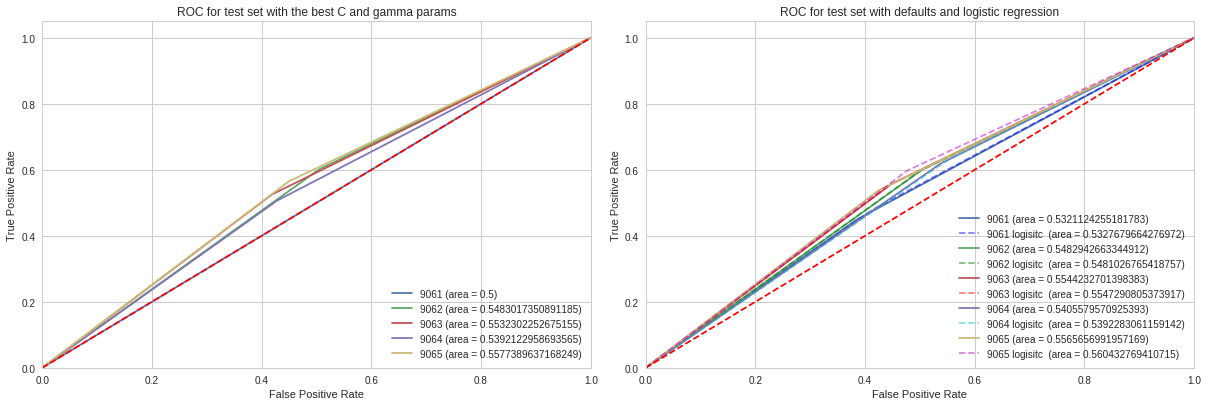

In [12]:
plt.subplot(121)

for s in stocks:
    reg_svm = svm_classification(dfs[s], 'rbf', C=df_css[s]['roc'].idxmax(), gamma=df_gammas[s]['roc'].idxmax())
    prediction = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], prediction)
    df_results['rbf-naive'][s] = logit_roc_auc
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, prediction)
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for test set with the best C and gamma params')
plt.legend(loc="lower right")

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.subplot(122)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'rbf')
    prediction = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], prediction)
    df_results['rbf-default'][s] = logit_roc_auc
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, prediction)
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
    
    reg_log = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    pred_log = reg_log.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_log)
    df_results['logistic'][s] = logit_roc_auc
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_log)
    plt.plot(fpr, tpr, c=colors[stocks.index(s)], linestyle='--', 
             label='{} (area = {})'.format(s + ' logisitc ', logit_roc_auc), alpha=0.5)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for test set with defaults and logistic regression')
plt.legend(loc="lower right")

plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

In [13]:
df_results

,logistic,rbf-naive,rbf-default
9061,0.532768,0.500000,0.532112
9062,0.548103,0.548302,0.548294
9063,0.554729,0.553230,0.554423
9064,0.539228,0.539212,0.540558
9065,0.560433,0.557739,0.556566


### Grid approach

We iterate over all combinations of parameters **C** and **gamma**.

This approach works usually better, but not for all cases.

In [14]:
best_c = {}
best_g = {}
best_score = {}

for s in stocks:
    print(s)
    best_score[s] = 0
    best_c[s] = -1
    best_g[s] = -1
    for c in cs:
        for g in gammas:
            reg_svm = svm_classification(dfs[s], 'rbf', C=c, gamma=g)
            prediction = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
            logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], prediction)
            if logit_roc_auc > best_score[s]:
                best_c[s] = c
                best_g[s] = g
                best_score[s] = logit_roc_auc

9061
9062
9063
9064
9065


##### Best parameters for grid approach

In [15]:
print('stock', '\t', 'C', '\t', 'gamma', '\t', 'best score')
for s in stocks:
    print(s, '\t', best_c[s], '\t', best_g[s], '\t', best_score[s])

stock 	 C 	 gamma 	 best score
9061 	 10 	 0.005 	 0.554041857775
9062 	 5 	 0.25 	 0.523164719389
9063 	 0.75 	 10 	 0.547251831251
9064 	 0.1 	 10 	 0.552403483567
9065 	 15 	 1 	 0.564800107061


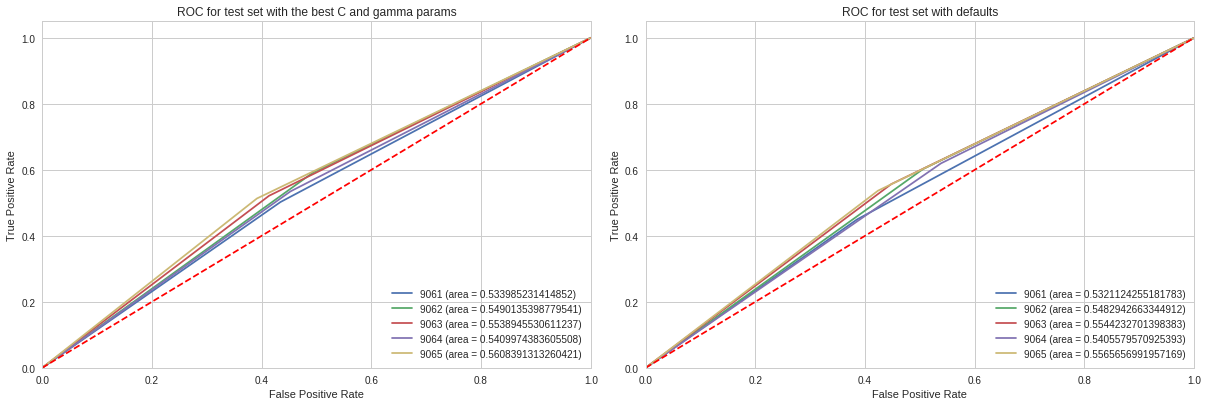

In [16]:
df_results['rbf-grid'] = np.zeros(len(stocks))
plt.subplot(121)

for s in stocks:
    reg_svm = svm_classification(dfs[s], 'rbf', C=best_c[s], gamma=best_g[s])
    prediction = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], prediction)
    df_results['rbf-grid'][s] = logit_roc_auc
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, prediction)
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for test set with the best C and gamma params')
plt.legend(loc="lower right")

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.subplot(122)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'rbf')
    prediction = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], prediction)
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, prediction)
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for test set with defaults')
plt.legend(loc="lower right")
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

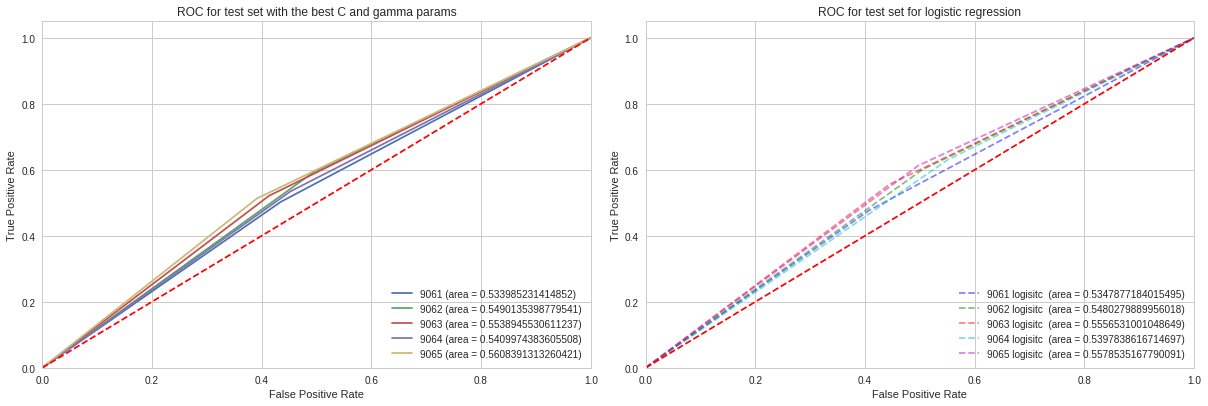

In [17]:
plt.subplot(121)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'rbf', C=best_c[s], gamma=best_g[s])
    prediction = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], prediction)
    df_results['rbf-grid'][s] = logit_roc_auc
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, prediction)
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for test set with the best C and gamma params')
plt.legend(loc="lower right")

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.subplot(122)
for s in stocks:
    reg_log = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    pred_log = reg_log.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_log)
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_log)
    plt.plot(fpr, tpr, c=colors[stocks.index(s)], linestyle='--', 
             label='{} (area = {})'.format(s + ' logisitc ', logit_roc_auc), alpha=0.5)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for test set for logistic regression')
plt.legend(loc="lower right")
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

In [18]:
df_results

,logistic,rbf-naive,rbf-default,rbf-grid
9061,0.532768,0.500000,0.532112,0.533985
9062,0.548103,0.548302,0.548294,0.549014
9063,0.554729,0.553230,0.554423,0.553895
9064,0.539228,0.539212,0.540558,0.540997
9065,0.560433,0.557739,0.556566,0.560839


# Conclusions


The **C** parameter for **rbf** kernel should be choosen for each stock separately. The choice of **C** paramter matters - the difference between roc_area scoring between the worst and best case is about $0.1$ for each stock of this choice. The only thing in common is that C should be bigger than $0.0001$. But suprisingly only for one of the stock data - the bigger **C** the better.


The **gamma** parameter for **rbf** kernel should be choosen for each stock separately. The choice of **gamma** doesn't seem to matter much though - the difference it can make is about $0.01$. 

The **C** and **gamma** should be choosen together, there is no point in picking the best one for each of them. Choosing them using *grid* approach gave small improvement for 3 stocks, for the rest default parameters worked better.

Comparing to logistic regression for each stock we have slightly worse results with "tunned" parameters. We have slightly better results for almost all stocks (except **2051**).

For **10795** we have better results with defult parameters than for logistic regression.

### Resources

1. [Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book](https://arxiv.org/abs/1512.03492) <a class="anchor-link" href="#1">¶</a>
2. [RBF kernel](https://chrisalbon.com/machine_learning/support_vector_machines/svc_parameters_using_rbf_kernel/)
3. [model_selection.GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)